In [14]:
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import h5py
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import dask
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.seterr(divide='ignore', invalid='ignore')

# dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
# from dask.distributed import Client

# these are functions from our homemade code
# from esio import EsioData as ed
# from esio import ice_plot
# from esio import import_data
# from esio import metrics
import metrics

# general plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from scipy.interpolate import InterpolatedUnivariateSpline


def mask_common_extent(ds_obs, ds_mod, max_obs_missing=0.1):
    ''' Define naive_fast that searches for the nearest WRF grid cell center.'''

    # Mask out areas where either observations or model are missing
    mask_obs = ds_obs.isnull().sum(dim='time') / ds_obs.time.size # Get fraction of missing for each pixel
    mask_mod = ds_mod.isel(fore_time=0).isel(init_time=0).isel(ensemble=0).notnull() # Grab one model to get extent
    mask_comb = (mask_obs <= max_obs_missing) & (mask_mod) # Allow 10% missing in observations
    mask_comb = mask_comb.squeeze() #(['ensemble','fore_time','init_time','fore_time']) # Drop unneeded variables

    # Apply and return
    ds_obs_out = ds_obs.where(mask_comb)
    ds_mod_out = ds_mod.where(mask_comb)
    ds_mod_out.coords['fore_time'] = ds_mod.fore_time # add back coords that were dropped

    return (ds_obs_out, ds_mod_out)


def calc_extent(da=None, region=None, extent_thress=0.15, fill_pole_hole=False):
    ''' Returns extent in millions of km^2 within all ocean regions (NO LAKES!)'''

    if 'x' not in da.dims:
        raise ValueError('x not found in dims.... might need to rename spatial dims')

    # TODO: Need to assert we pass in a DataArray of sic
    extent = (( da.where(region.mask.isin(region.ocean_regions)) >= extent_thress ).astype('int') * region.area).sum(dim='x').sum(dim='y')/(10**6)

    # Mask out zero extents (occurs if ensemble changes size)
    extent = extent.where(extent>0)

    # Add in pole hole (optional)
    if fill_pole_hole:
        extent = extent + (da.hole_mask.astype('int') * region.area).sum(dim='x').sum(dim='y')/(10**6)

    return extent


def agg_by_domain(da_grid=None, ds_region=None, extent_thress=0.15, fill_pole_hole=False):
    # TODO: add check for equal dims
    ds_list = []
    for cd in ds_region.nregions.values:
        # Get name
        region_name = ds_region.region_names.sel(nregions=cd).values
        # Check we want it (exclude some regions)
        if not region_name in ['Ice-free Oceans', 'null','land outline', 'land' ]:
            # Make mask
            cmask = ds_region.mask==cd
            # Multiple by cell area to get area of sea ice
            da_avg = (da_grid.where(cmask==1) >= extent_thress).astype('int') * ds_region.area.where(cmask==1)
            # Sum up over current domain and convert to millions of km^2
            da_avg = da_avg.sum(dim=['y','x']) / (10**6)
            # TODO: Add option to add in pole hole if obs and central arctic
            if fill_pole_hole:
                raise ValueError('Not implemented')

            # Add domain name
            da_avg['nregions'] = cd
            da_avg['region_names'] = region_name
            ds_list.append(da_avg)
    return xr.concat(ds_list, dim='nregions')


def agg_metric_domain(da_grid=None, ds_region=None):

    ds_list = []
    for cd in ds_region.nregions.values:
        # Get name
        region_name = ds_region.region_names.sel(nregions=cd).values
        # Check we want it (exclude some regions)
        if not region_name in ['Ice-free Oceans', 'null','land outline', 'land' ]:
            # Make mask
            cmask = ds_region.mask==cd
            # Mask out
            da_avg = da_grid.where(cmask==1)
            # Average
            da_avg = da_avg.mean(dim=['x','y'])

            # Add domain name
            da_avg['nregions'] = cd
            da_avg['region_names'] = region_name
            ds_list.append(da_avg)
    return xr.concat(ds_list, dim='nregions')


def get_season_start_date(ctime):
    X = ctime.astype(object)
    if X.month<=8:
        yyyy = X.year-1
    else:
        yyyy = X.year
    return np.datetime64(str(yyyy)+'-09-01')


def get_median_ice_edge(ds, ystart='1981', yend='2012', sic_threshold=0.15):
    ''' Calc NSIDC median sea ice edge between 1981-2010'''
    median_ice = ds.sel(time=slice(ystart, yend)) #.drop(['coast','land','missing'])
    # Calc "Extent" (1 or 0)
    median_ice['sic'] = (median_ice.sic >= sic_threshold).astype('int')
    DOY = [x.timetuple().tm_yday for x in pd.to_datetime(median_ice.time.values)]
    median_ice['time'] = DOY
    median_ice.reset_coords(['hole_mask'], inplace=True)
    median_ice.load()
    median_ice = median_ice.groupby('time').median(dim='time')
    median_ice_fill = median_ice.where(median_ice.hole_mask==0, other=1).sic # Fill in pole hole with 1 (so contours don't get made around it)
    return median_ice_fill


def calc_IAD(da, sic_threshold=0.15, DOY_s=1, time_dim='time'):
    ''' Calc the Ice Advance Day (first) by Calender Year. '''
    da = da.rename({time_dim:'time'})
    #dat=da.where(da.notnull(),other =0) # get rid of nan
    #damin = dat.argmin(axis=0)  # find the time dim of min
    #dat = dat.where(dat<damin, other =0.05)  # fill with small value before min
    iad = (da > sic_threshold).reduce(np.argmax, dim='time') # Find index of first ice free
    #iad = iad.where(da.isel(time=0).notnull()) # Apply Orig mask
    # Convert to Day of Year by adding the first time
    iad = iad + DOY_s
    return iad


def calc_IFD(da, sic_threshold=0.15, DOY_s=1, time_dim='time'):
    ''' Calc the Ice Free Day (first) by Calender Year. '''
    da = da.rename({time_dim:'time'})
    ifd = (da < sic_threshold).reduce(np.argmax, dim='time') # Find index of first ice free
    ifd = ifd.where(da.isel(time=0).notnull()) # Apply Orig mask
    # Convert to Day of Year by adding the first time
    ifd = ifd + DOY_s
    return ifd


def calc_IFD_10day(da, sic_threshold=0.5, DOY_s=1, time_dim='time', Nday=10, default_ice_free=None):
    ''' Calc the Ice Free Day (first) by Calender Year. 
    Returns day of year (doy) for each pixel when the sic value dropped below the sic_threshold 
    and stayed below that threshold for atleast Nday days.
    '''
    da = da.rename({time_dim:'time'})

    # Here we find pixels WITHOUT (<sic_threshold) Ice!!!
    sip_Xday = (da < sic_threshold).rolling(min_periods=1, center=False, time=Nday).sum().where(da.isel(time=0).notnull()) 

    # Now values range from 0 to Nday, keep only Nday pixel values, rescale them to 1 (end up with 0 with ice and 1 with ocean over past 10 days)
    sip_Xday_adj = sip_Xday.where(sip_Xday == Nday, other=0).where(da.isel(time=0).notnull())
    sip_Xday_adj = sip_Xday_adj.astype('float') / Nday

    # Now reduce over time dime, and find the first "1" value for each pixel (which is the last day of ice presence, with at least 10 days following ice free)
    ifd = sip_Xday_adj.reduce(np.argmax, dim='time') # Find index of first ice free
    #plt.figure()
    #ifd.plot()

    # Convert to Day of Year by adding the first time
    ifd = ifd + DOY_s - Nday - 1 # Add DOY_s and subtract the Nday window (rolling returns the right side label "trailing")
    #plt.figure()
    #ifd.plot()

    # Classify pixels 
    # 1) that were ice free at first index time to the default ice free date (i.e. June 1st)
    ifd = ifd.where(ifd > DOY_s, other=default_ice_free)
    #plt.figure()
    #ifd.plot()

    # 2) that never melted (perenial) to NaN
    # Grab last model time (end of Sept) and get mask of where ice is
    #perenial_ice_mask = (da.isel(time=da.time.size-1) >= sic_threshold)
    # instead make the perennial mask true ice is never below 0.5
    perenial_ice_mask = (da.min(dim='time') >= sic_threshold)

    ifd = ifd.where(~perenial_ice_mask, other=275)

    #plt.figure()
    #ifd.plot()

    # Apply Orig mask
    ifd = ifd.where(da.isel(time=0).notnull())

    return ifd


def calc_hist_sip(ds_sic=None, ystart='2007', yend='2017', sic_threshold=0.15, fill_pole_hole=False):
    ''' Calc historical SIP for a range of years '''
    
    # Trim by years
    ds_sic = ds_sic.sel(time=slice(ystart, yend))

    print(ds_sic)
    # Get landmask 
    land_mask = ds_sic.isel(time=-1).notnull()
    
    # Convert sea ice presence
    ds_sp = (ds_sic >= sic_threshold).astype('int') # This unfortunatly makes all NaN -> zeros...
    
    # Mask land before fill in pole hole since it wipes it out
    ds_sp = ds_sp.where(land_mask)
    
    if fill_pole_hole:
        # Fill in pole hole with 1 (so contours don't get made around it)
        # A minor mistake if pole hole was already filled with avg SIC
        ds_sp = ds_sp.where(ds_sic.hole_mask==0, other=1).drop('hole_mask')
    
    # Add DOY
    DOY = [x.timetuple().tm_yday for x in pd.to_datetime(ds_sp.time.values)]
    ds_sp['time'] = DOY
    
    # Calculate mean SIP
    ds_sip = ds_sp.groupby('time').mean(dim='time')
    
    return ds_sip


def nanSum(da=None, dim=None):
    ''' Return nan sum for pixels where we have atleast 1 NaN value. '''
    return da.sum(dim=dim).where(da.notnull().sum(dim=dim) > 0 )


def format_obs_like_model(ds_mod, ds_obs):
    ''' Reformats observational dataset to be structured like a model forecast dataset
    Format obs like model (i.e. ensemble x init_time x forecast_time) '''

    ds_obs_X = (ds_mod.copy() * np.nan).load() # Have to call load here to assign ie below
    for (i, e) in enumerate(ds_obs_X.ensemble):
        for (j, it) in enumerate(ds_obs_X.init_time):
            ds_obs_X[i, j, :] = ds_obs.sel(time = ( ds_mod.init_time.sel(init_time=it) + ds_mod.fore_time).values )

    return ds_obs_X


def dt64_to_dd(dt64):
    ''' Converts datetime64[ns] into datetime.datetime'''
    return dt64.values.astype('M8[D]').astype('O')


def trim_common_times(ds_obs=None, ds_mod=None, freq=None):
    ''' Trim an observed and modeled dataset to common start and end dates (does not
    insure internal times are the same) '''

    if 'valid_time' not in ds_mod.coords:
        ds_mod.coords['valid_time'] = ds_mod.init_time + ds_mod.fore_time

    # Get earliest and latest times
    print(ds_mod.valid_time.max().values)
    print(ds_obs.time.values[-1])
    T_start = np.max([ds_obs.time.values[0], ds_mod.init_time.min().values])
    T_end = np.min([ds_obs.time.values[-1], (ds_mod.valid_time.max()).values])


    # Subset Obs
    ds_obs_out = ds_obs.where((ds_obs.time >= T_start) & (ds_obs.time <= T_end), drop=True)
    # Subset Model
    #ds_mod_out = ds_mod.where(((ds_mod.init_time >= T_start) &
    #                          ((ds_mod.init_time+ds_mod.fore_time <= T_end).all(dim='fore_time'))), drop=True) # If forecasts times are long, this drops too much data

    # For model, we want to drop any valid times before T_start
    ds_mod = ds_mod.where(ds_mod.init_time >= T_start, drop=True)

    # AND set to NaN any valid times after T_end (updated)

    ds_mod_out = ds_mod.where( (ds_mod.init_time >= T_start) &
                          (ds_mod.valid_time <= T_end))

    # Expand obs time to have missing until model valid forecasts
    #print(ds_obs_out.time.max().values)
    #print(valid_time.max().values)
    #print(freq)
    #offset1 = np.timedelta64(40, 'D') # A shift to handel case of monthly data to have extra missing (NaN) obs
    new_time = pd.date_range(ds_obs_out.time.max().values, ds_mod.valid_time.max().values, freq=freq) # new time we don't have obs yet (future)
    new_obs_time = xr.DataArray(np.ones(new_time.shape)*np.NaN,  dims='time', coords={'time':new_time}) # new dataArray of missing
    ds_obs_out_exp = ds_obs_out.combine_first(new_obs_time) # Merge
    T_end = ds_obs_out_exp.time.max().values # new end time

    print(ds_mod_out.valid_time.max().values)
    print(ds_obs_out_exp.time.max().values)

    assert (ds_mod_out.valid_time).max().values <= ds_obs_out_exp.time.max().values, 'Model out contains valid times greater then end'

    print(T_start, T_end)
    assert T_start < T_end, 'Start must be before End!'

    return ds_obs_out_exp, ds_mod_out


def clim_mu_sigma(ds_obs, method='MK'):
    ''' Calculate the climatological mean and standard deviation following:
    MK - Maximum knowledge (use all observations times)
    OP - Operatioanl approach (use only observations from past (before initialization time))
    '''

    if method=='MK':
        y = ds_obs.values
        x = np.arange(0,ds_obs.time.size,1)
    else:
        raise ValueError('Method not found.')

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    predict_y = intercept + slope * x
    pred_error = y - predict_y
    sigma = np.std(pred_error)
    mu = np.mean(y)

    return (mu, sigma)


def NRMSE(ds_mod, ds_obs, sigma):
    ''' Normalized RMSE (NRMSE)'''

    #Assert obs has been formated like model
    assert ds_mod.dims==ds_obs.dims

    #TODO: Uncertain here to take mean over init_time or fore_time ????
    a = xr.ufuncs.sqrt( ((ds_mod - ds_obs)**2).mean(dim='ensemble').mean(dim='fore_time') )
    b = xr.ufuncs.sqrt( 2*(sigma**2) ) # add time variance for OP option

    NRMSE =  1 - (a / b)
    return NRMSE


def IIEE(da_mod=None, da_obs=None, region=None, sic_threshold=0.15, testplots=False,
        customDomain=None):
    ''' The Integrated Ice‐Edge Error Goessling 2016'''
    
    # Input
    # da_mod/da_obs - DataArray of sic from model/observations
    
    # Output
    # IEEE - Area of IEEE in millions of km^2, 
    
    # Should already be formated the same
    assert (sorted(da_mod.dims) == sorted(da_obs.dims)), "Dims should be the same."
    
    # spatial dims in model and obs should be 'x' and 'y' to match regions var names
    assert ('x' in da_mod.dims), "'x' and 'y' should be dims."
    assert ('y' in da_obs.dims), "'x' and 'y' should be dims"
    
    # Reduce to sea ice presence
    mod_sip = (da_mod >= sic_threshold).where(da_mod.notnull())
    obs_sip = (da_obs >= sic_threshold).where(da_obs.notnull())

    # If we have defined a customDomain, use that to mask out model and observations
    if customDomain is None:
        # Mask to regions of Arctic we are interested in (default option)
        mod_sip = mod_sip.where(region.mask.isin(region.ocean_regions))
        obs_sip = obs_sip.where(region.mask.isin(region.ocean_regions))
    else:
        mod_sip = mod_sip.where(customDomain)
        obs_sip = obs_sip.where(customDomain)
    
    if testplots:
        plt.figure()
        (abs(mod_sip - obs_sip)).plot()
    
    # Calculate both terms (over and under area) in millions of km^2
    IIEE = (abs(mod_sip - obs_sip) * region.area ).sum(dim=['x','y'])/(10**6)
    # Differencing mod-obs, will take only non-missing pixels (inner)
    # So models with 
    
    # Remove IIEE values of zero where model AND observation were missing
    have_mod_and_obs = (mod_sip.sum(['x','y']) > 0) & (obs_sip.sum(['x','y']) > 0) 
    IIEE = IIEE.where(have_mod_and_obs)
    
    return IIEE


def _BSS(mod=None, obs=None):
    return ((mod-obs)**2)


def BrierSkillScore(da_mod_sip=None, 
                    da_obs_ip=None, 
                    region=None, 
                    testplots=False,
                    customDomain=None):
    '''
    Brier Skill Score
    ----------
    Parameters:
    da_mod_sip : DataArray
        DataArray of modeled sea ice probabilies (0-1)
    da_obs_ip : DataArray
        DataArray of observed sea ice presence (0 or 1)
    time_dim: String
        Name of time dimension to take mean over when calculating the BSS
    region : DataSet
        DataSet contain spatial location of Arctic regions
    testplots : Boolean
        Flag to turn on test plots    
        
    Returns:
    BSS = Brier Skill Score
    '''
    
    # Should already be formated the same
    assert (sorted(da_mod_sip.dims) == sorted(da_obs_ip.dims)), "Dims should be the same."
    
    # spatial dims in model and obs should be 'x' and 'y' to match regions var names
    assert ('x' in da_mod_sip.dims), "'x' and 'y' should be dims."
    assert ('y' in da_obs_ip.dims), "'x' and 'y' should be dims"
        
    # If we have defined a customDomain, use that to mask out model and observations
    if customDomain is None:
        # Mask to regions of Arctic we are interested in (default option)
        da_mod_sip = da_mod_sip.where(region.mask.isin(region.ocean_regions))
        da_obs_ip = da_obs_ip.where(region.mask.isin(region.ocean_regions))
    else:
        da_mod_sip = da_mod_sip.where(customDomain)
        da_obs_ip = da_obs_ip.where(customDomain)
        
    # Calculate Brier Skill Score
    BSS = _BSS(mod = da_mod_sip, 
               obs = da_obs_ip)
    
    if testplots:
        plt.figure()
        da_mod_sip.plot()
        plt.figure()
        da_obs_ip.plot()   
        plt.figure()
        BSS.plot()
            
    return BSS


def _lowessfit(x=None, y=None, dummy=None):

    # lowess smooth and then fit with polynomial
    # returns fit parameters output from polyfit

    nonans = np.logical_or(np.isnan(x), np.isnan(y))
    x_nonans = x[~nonans]
    y_nonans = y[~nonans]
    order = 2  # 2 = quadratic

    if y_nonans.size == 0:
        fitparms = np.empty(order+1) * np.nan
    else: 
        sumy = np.sum(y_nonans)
        leny = 1.0*np.size(y_nonans)
        fitparms = np.zeros(order+1)
        if (sumy>0. and sumy != leny):  # had sumy < leny here but this seems more general
            # lowess will return our "smoothed" data with a y value for at every x-value
            # important for eliminating problems with outliers
            lowess = sm.nonparametric.lowess(y_nonans, x_nonans, frac=.3)  # higher frac is smoother
            
            # unpack the lowess smoothed points to their values
            lowess_y = list(zip(*lowess))[1]
            
            if (len(x_nonans)!=len(lowess_y)):
                print('error fitting! ')
                print('sumy, leny, len(x_nonans), len(lowess_y) ', sumy, leny, len(x_nonans), len(lowess_y))
            else: 
                # we can use a higher order fit safely since we smoothed
                # smoothing was much less important than the 2nd order fit
                fitparms = np.polyfit(x_nonans, lowess_y, order)
        elif (sumy==leny):
            fitparms[order] = 1.0

    return (fitparms)

def LowessQuadFit(obj, xdim):
    time_nums = xr.DataArray(obj[xdim].values.astype(np.float),
                             dims=xdim,
                             coords={xdim: obj[xdim]},
                             name=xdim)
    # could not figure out the output_size error so
    # tried other route of sending a dim of same size as input and output
    # be sure to change here if alter the polyfit order in _lowessfit 
    dummy = xr.DataArray(np.random.randn(3), coords={'pdim': [0, 1, 2]}, dims=('pdim'))

    p1 = xr.apply_ufunc(_lowessfit, time_nums, obj, dummy,
                                vectorize=True,
                                input_core_dims=[[xdim], [xdim], ['pdim']],
                                output_core_dims=[['pdim']],
                                output_dtypes=[np.float],
                                dask='parallelized')
    return (p1)


def _improvedlowessfit(x=None, y=None, dummy=None, maxorder = 2):
    # lowess smooth and then fit with polynomial
    # returns fit parameters output from polyfit

    order = maxorder # to start

    basevalue=np.nanmean(y[0:10])
    yn=np.where(y<basevalue*0.995, y, np.nan)
    
    if (np.count_nonzero(np.isnan(yn[-5:]))>1):  # >1 nan values in last 5 yrs 
        #print('Too many nans in last 5 yrs, skip fit and use mean ')
        fitparms = np.zeros(maxorder+1)
        fitparms[maxorder] = np.nanmean(y[-5:])  # use y not yn!
        return (fitparms)  # and we are done

    if (np.count_nonzero(np.isnan(yn[0:14]))>10):  # >10 nan values in first 15 yrs 
        #print('Too many nans in first half, use first order fit on second half')
        order = 1
        y=y[15:]
        x=x[15:]
    #else:
        #print('normal second order case')

    nonans = np.logical_or(np.isnan(x), np.isnan(y))
    x_nonans = x[~nonans]
    y_nonans = y[~nonans]

    if y_nonans.size == 0:
        
        fitparms = np.empty(order+1) * np.nan
    else: 
        sumy = np.sum(y_nonans)
        leny = 1.0*np.size(y_nonans)
        fitparms = np.zeros(order+1)
        if (sumy>0. and sumy != leny):  # had sumy < leny here but this seems more general
            # lowess will return our "smoothed" data with a y value for at every x-value
            # important for eliminating problems with outliers
            lowess = sm.nonparametric.lowess(y_nonans, x_nonans, frac=.3)  # higher frac is smoother

            # unpack the lowess smoothed points to their values
            lowess_y = list(zip(*lowess))[1]

            if (len(x_nonans)!=len(lowess_y)):
                print('error fitting! ')
                print('sumy, leny, len(x_nonans), len(lowess_y) ', sumy, leny, len(x_nonans), len(lowess_y))
            else: 
                # we can use a higher order fit after lowess smoothing
                # smoothing was much less important than the 2nd order fit
                fitparms = np.polyfit(x_nonans, lowess_y, order)
        elif (sumy==leny):
            fitparms[order] = 1.0

        if order == 1:
            tmp=np.copy(fitparms) #save 
            fitparms = np.zeros(maxorder+1)
            fitparms[maxorder] = tmp[1]
            fitparms[maxorder-1] = tmp[0]
              
    return (fitparms) # too bad cannot return more than one variable. oh well

def ImprovedLowessFit(obj, xdim, maxorder):
    time_nums = xr.DataArray(obj[xdim].values.astype(np.float),
                             dims=xdim,
                             coords={xdim: obj[xdim]},
                             name=xdim)
    
    dummy = xr.DataArray(np.random.randn(maxorder+1), coords={'pdim': np.arange(0,maxorder+1,1)}, dims=('pdim'))
    
    p1 = xr.apply_ufunc(_improvedlowessfit, time_nums, obj, dummy, maxorder,
                                vectorize=True,
                                input_core_dims=[[xdim], [xdim], ['pdim'], []],
                                output_core_dims=[['pdim']],
                                output_dtypes=[np.float],
                                dask='parallelized')
    
    return (p1)


def _lowessext(x=None, y=None, pyear=None):

    # lowess does not work if data have nans
    nonans = np.logical_or(np.isnan(x), np.isnan(y))
    x_nonans = x[~nonans]
    y_nonans = y[~nonans]

    if y_nonans.size == 0:
        znew = np.nan
    else: 

        # lowess will return our "smoothed" data with a y value for at every x-value
        # important for eliminating problems with outliers
        lowess = sm.nonparametric.lowess(y_nonans, x_nonans, frac=.3)  # higher frac is smoother

        # unpack the lowess smoothed points to their values
        lowess_y = list(zip(*lowess))[1]

        # we can use a higher order fit safely since we smoothed
        # smoothing was much less important than the 2nd order fit
        gl = np.polyfit(x, lowess_y, 2)
        hl = np.poly1d(gl)

        znew = hl(pyear)
        #    zfit = hl(x)
        #    return (znew, zfit)

    return (znew)


def LowessFitModel(obj, xdim, pyear):
    time_nums = xr.DataArray(obj[xdim].values.astype(np.float),
                             dims=xdim,
                             coords={xdim: obj[xdim]},
                             name=xdim)
    predictant = xr.apply_ufunc(_lowessext, time_nums, obj, pyear,
                                vectorize=True,
                                input_core_dims=[[xdim], [xdim], []],
                                output_core_dims=[[]],
                                output_dtypes=[np.float],
                                dask='parallelized')
    
    return predictant


def _lrm(x=None, y=None, pyear=None):
    '''wrapper that returns the predicted values from a linear regression fit of x and y'''
    # TODO remove hardcoded 2018 (was not passing more then 2 arg???)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    predict_y = intercept + slope * pyear
    return predict_y


def linearRegressionModel(obj, xdim, pyear):
    time_nums = xr.DataArray(obj[xdim].values.astype(np.float),
                             dims=xdim,
                             coords={xdim: obj[xdim]},
                             name=xdim)
    predictant = xr.apply_ufunc(_lrm, time_nums, obj, pyear,
                           vectorize=True,
                           input_core_dims=[[xdim], [xdim], []],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')

    return predictant


def _remove_trend(x, y):
    '''wrapper that removes the trend from a linear regression fit of x and y'''

    # Drop indices where both x and y are missing
    nonans = np.logical_or(np.isnan(x), np.isnan(y))
    x_nonans = x[~nonans]
    y_nonans = y[~nonans]

    if y_nonans.size == 0:
        return y  # Return original y, because all values were missing
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_nonans, y_nonans)
        detrend_y = y - (slope * x + intercept)
        return detrend_y


def detrend(obj, xdim):
    time_nums = xr.DataArray(obj[xdim].values.astype(np.float),
                             dims=xdim,
                             coords={xdim: obj[xdim]},
                             name=xdim)
    detrend_y = xr.apply_ufunc(_remove_trend, time_nums, obj,
                           vectorize=True,
                           input_core_dims=[[xdim], [xdim]],
                           output_core_dims=[[xdim]],
                           output_dtypes=[np.float],
                           dask='parallelized')

    return detrend_y


def get_DOY(da):
    ''' Return the day of the year given a datetime64 DataArray'''
    if da.size==1:
        DOY_all = [x.timetuple().tm_yday for x in pd.to_datetime([da.values])]
    else:
        DOY_all = [x.timetuple().tm_yday for x in pd.to_datetime(da.values)]
    return DOY_all

In [3]:
# customize this cell

# this is where my figures go
fig_dir='./figures/'
CB_lon=[-105.0597]
CB_lat=[ 69.1169]  # 69.1169° N, 105.0597° W

In [4]:
import xarray as xr

'''
#stero_grid_file = E.obs['NSIDC_0051']['grid']

stero_grid_file='stereo_gridinfo.nc'
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')

# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)
'''

stero_grid_file = "stereo_gridinfo.nc"
obs_grid = xr.open_dataset(stero_grid_file)

# Fix any values slightly above 90
obs_grid["grid_corner_lat"] = obs_grid.grid_corner_lat.where(
    obs_grid.grid_corner_lat < 90, other=90
)

# Also ensure centers are within [-90, 90]
obs_grid["grid_center_lat"] = obs_grid.grid_center_lat.clip(-90, 90)


In [5]:
def MakeModelDataSet(files):
# read in the model data. It has ice concentration (aice) and thickness (hi)
    dm=xr.open_mfdataset(files,decode_times=False)
    dm.coords['fore_time']=('time',(dm.time-dm.time.values[0])/24)
    dm=dm.swap_dims({'time':'fore_time'})
    dm=dm.drop('time')
    cyear = init_time[0:4] 
    cmonth = init_time[4:6]
    cday = init_time[6:8]
    dm.coords['init_time'] = np.datetime64(cyear+'-'+cmonth+'-'+cday)
    dm=dm = dm.assign_coords(lon=(dm.lon % 360)).roll(lon=(dm.dims['lon'] // 2))
    return dm


def MakeDataSet2(FILE_NAME):
    # function for reading the 12.5 km observations of sea ice concentration 

    SIC = '/HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_ICECON_DAY'
    LAT = '/HDFEOS/GRIDS/NpPolarGrid12km/lat'
    LON = '/HDFEOS/GRIDS/NpPolarGrid12km/lon'
    NI = '/XDim'
    NJ = '/YDim'

    f=h5py.File(FILE_NAME, mode='r')
    data = f[SIC][:]
    lat=f[LAT][:]
    lon=f[LON][:]
    ni=f[NI][:]
    nj=f[NJ][:]

    #print(data.shape)
    #print(lat.shape)
    #print(ni.shape)
    #print(nj.shape)

    ds = xr.DataArray(np.transpose(data), dims=["ni", "nj"])
    ds.name = 'sic'
    lat = xr.DataArray(np.transpose(lat), dims=["ni", "nj"])
    lon = xr.DataArray(np.transpose(lon), dims=["ni", "nj"])
    ds=ds.where(ds<=100, other=np.nan)
    ds.coords['lon'] = lon
    ds.coords['lat'] = lat
    ds.coords['nj'] = nj #np.flip(nj)
    ds.coords['ni'] = ni

    result = FILE_NAME.find('he5') 
    date = FILE_NAME[result-9:result-1]
    #print(date, date[0:4], date[4:6], date[6:8])
    cyear = date[0:4] 
    cmonth = date[4:6]
    cday = date[6:8]

    # ds.coords['time'] = np.datetime64(cyear+'-'+cmonth+'-'+cday)
    ds.coords['time'] = np.datetime64(f"{cyear}-{cmonth}-{cday}", 'ns')

    ds.time

    #print('\n\nTake a look at the dataarrray we made \n')
    #print(ds)
    f.close()

    return (ds, lat, lon)

In [6]:
# some pleasant colormaps

cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
cmap_c.set_bad(color = 'lightgrey')

cmap_std = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_std.set_bad(color = 'lightgrey')

cmap_b =  matplotlib.colors.ListedColormap(sns.color_palette("binary", 2))
cmap_b.set_bad(color = 'None')

In [7]:
def multi_polar_axis(ncols, nrows, Nplots, sizefcter=1, extent=None, central_longitude=0):
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=central_longitude)},
        figsize=(ncols*sizefcter, nrows*sizefcter)
    )
    axes = axes.flat[:Nplots]  # flatten and limit to Nplots
    for ax in axes:
        ax.set_extent(extent, crs=ccrs.NorthPolarStereo(central_longitude=central_longitude))
        ax.coastlines(linewidth=0.5)
    return fig, axes

saved  ./figures/SIC_Allyears_2013-2021_0520_forward.png


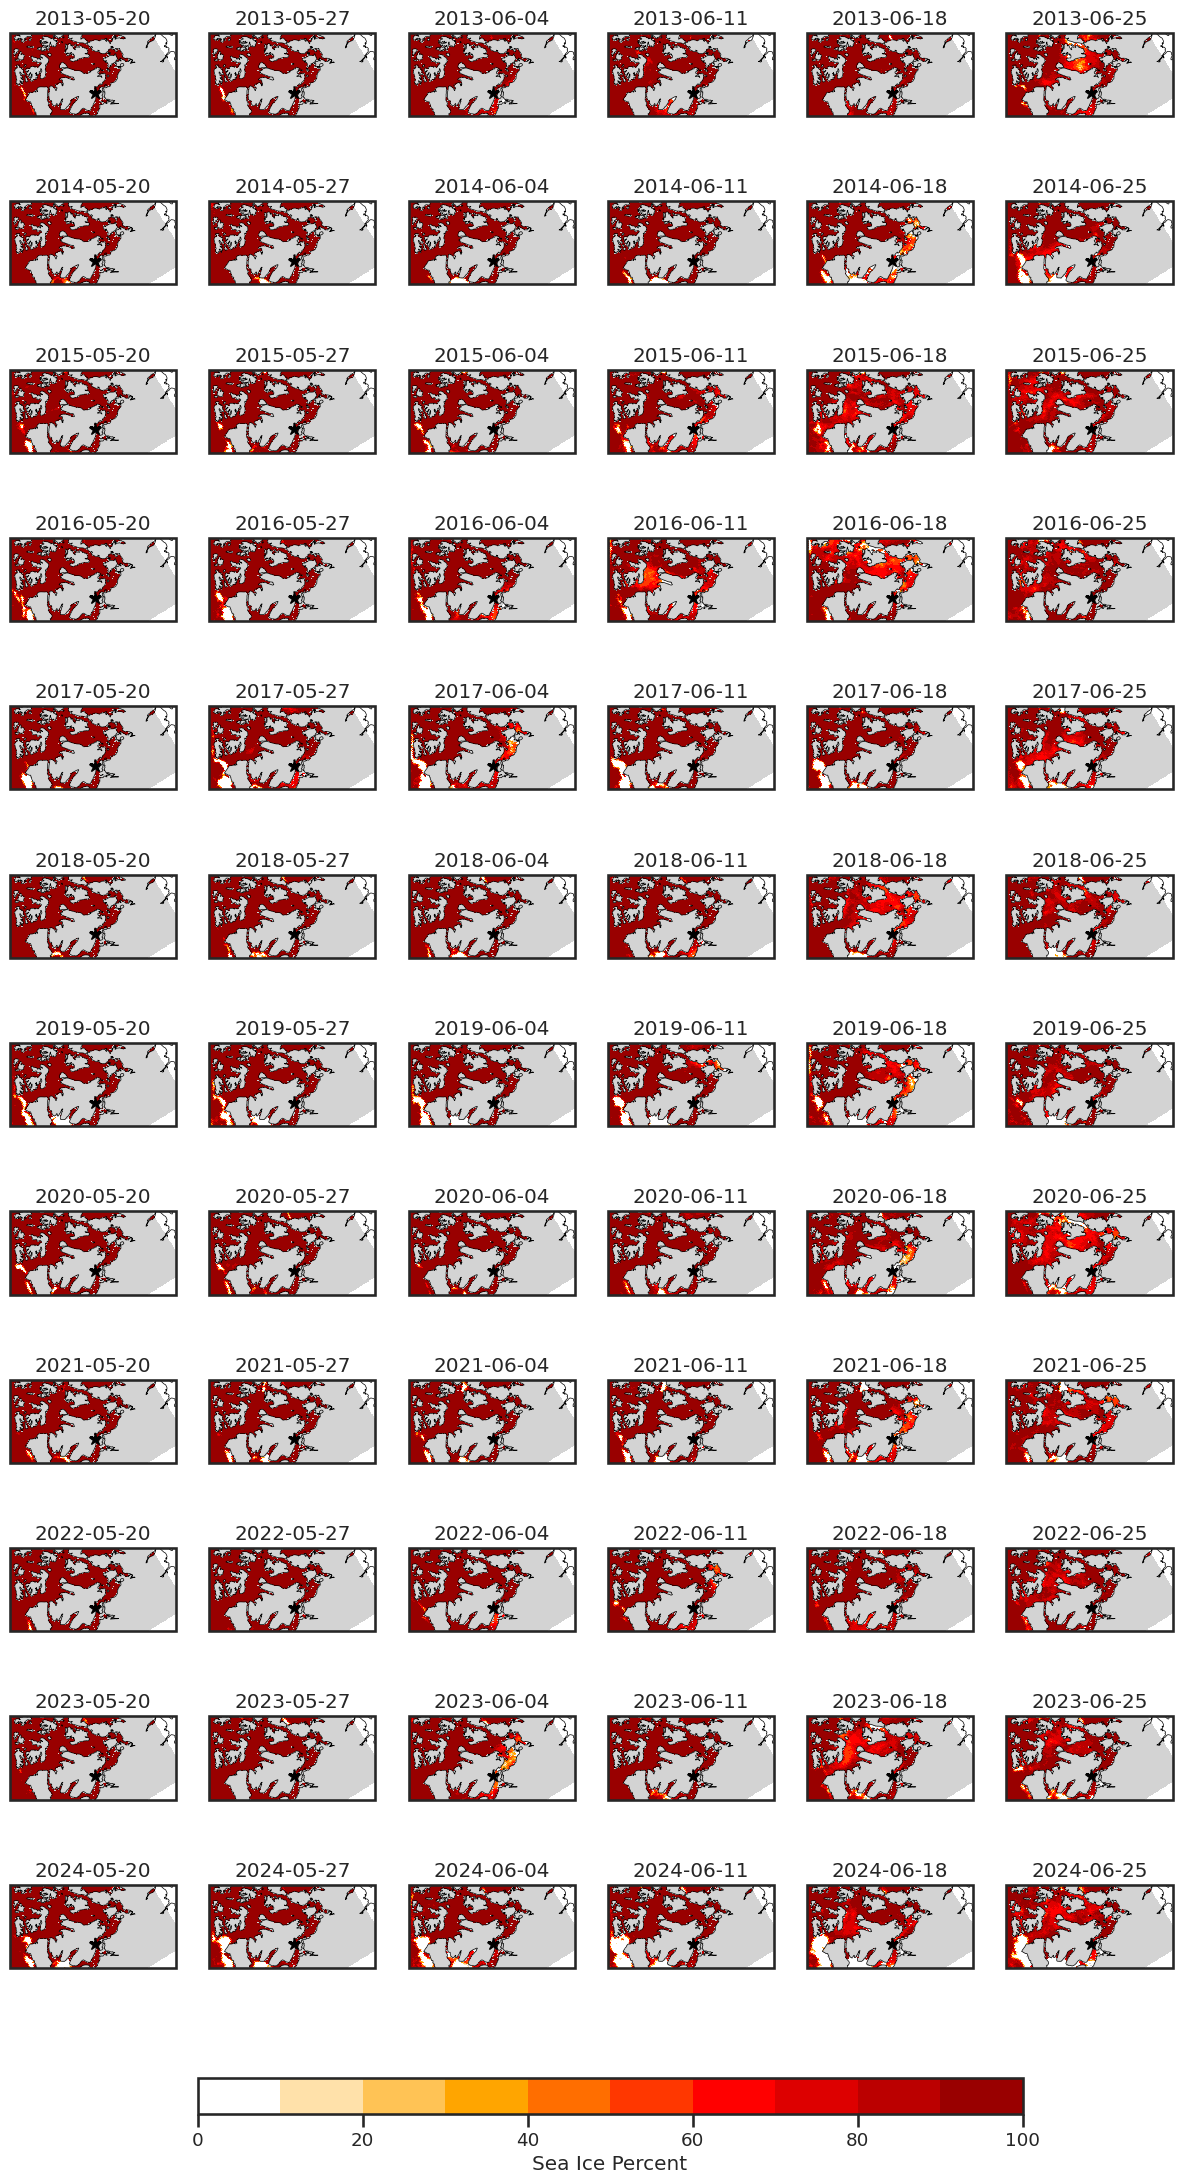

In [9]:
# reads in obs and plots every 5 days as defined by dates array, for every year 2013-2021
dates=['0422','0427','0502','0507']
dates=['0425','0430','0505','0510']
dates=['0502','0507','0512','0517']
dates=['0503','0508','0513','0518']
dates=['0506','0511','0516','0521']
dates=['0506','0511','0516','0521']
dates=['0511','0516','0521','0524']
dates=['0520','0527','0604','0611','0618','0625']


sns.set_context("talk", font_scale=0.8, rc={"lines.linewidth": 2.5})
#kivalina_lon=[-164.5333+.75] # move inland so can see the ocean nearest
#kivalina_lat=[ 67.7269]
kivalina_lon=[-105.0597-3]
kivalina_lat=[ 69.1169]  #69.1169° N, 105.0597° W
f_out = os.path.join(fig_dir,'SIC_Allyears_2013-2021_'+dates[0]+'_forward.png')

c_vmin=0
c_vmax=100

ncols=3
nrows=2021-2013+4
ncols=6
NPLOTS=nrows*ncols+1
sizefcter=2
#crExt = [1800000.0, 2400000.0, -1500000.0, -1000000.0] # (x0, x1, y0, y1) 
crExt = [1000000.0, 3000000.0, -1500000.0, -500000.0] # (x0, x1, y0, y1) 
f, axes = multi_polar_axis(
    ncols=ncols, nrows=nrows, Nplots=NPLOTS, sizefcter=sizefcter,
    extent=crExt, central_longitude=193-360
)
f.set_size_inches(ncols*2.5, nrows*2) # tinker a bit

i=0
for yr in np.arange(2013,2025):
    for j in np.arange(0,6):
        date=dates[j]
        FILE_NAME = '/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+date+'.he5'
        try:
            sic, lat, lon = MakeDataSet2(FILE_NAME)
            sic= sic.isel(nj=slice(420,625)).isel(ni=slice(100,240))

            axi=axes[i]
            p = sic.plot.pcolormesh(ax=axi, x='lon', y='lat', 
                          transform=ccrs.PlateCarree(), add_colorbar=False,
                          cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
            axi.plot([kivalina_lon], [kivalina_lat], color='k', marker='*',
                         transform=ccrs.PlateCarree())  # because using lon, lat                
            axi.set_title("{Y}-{M}-{D}".format(Y=str(yr),M=date[0:2],D=date[2:4]))
        except:
            print('No data yet')
        i=i+1

    f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .55, 0.015]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=
                  'Sea Ice Percent', orientation='horizontal')

# Save to file
f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


saved  ./figures/SIC_Allyears_2013-2021_0520_forward.png


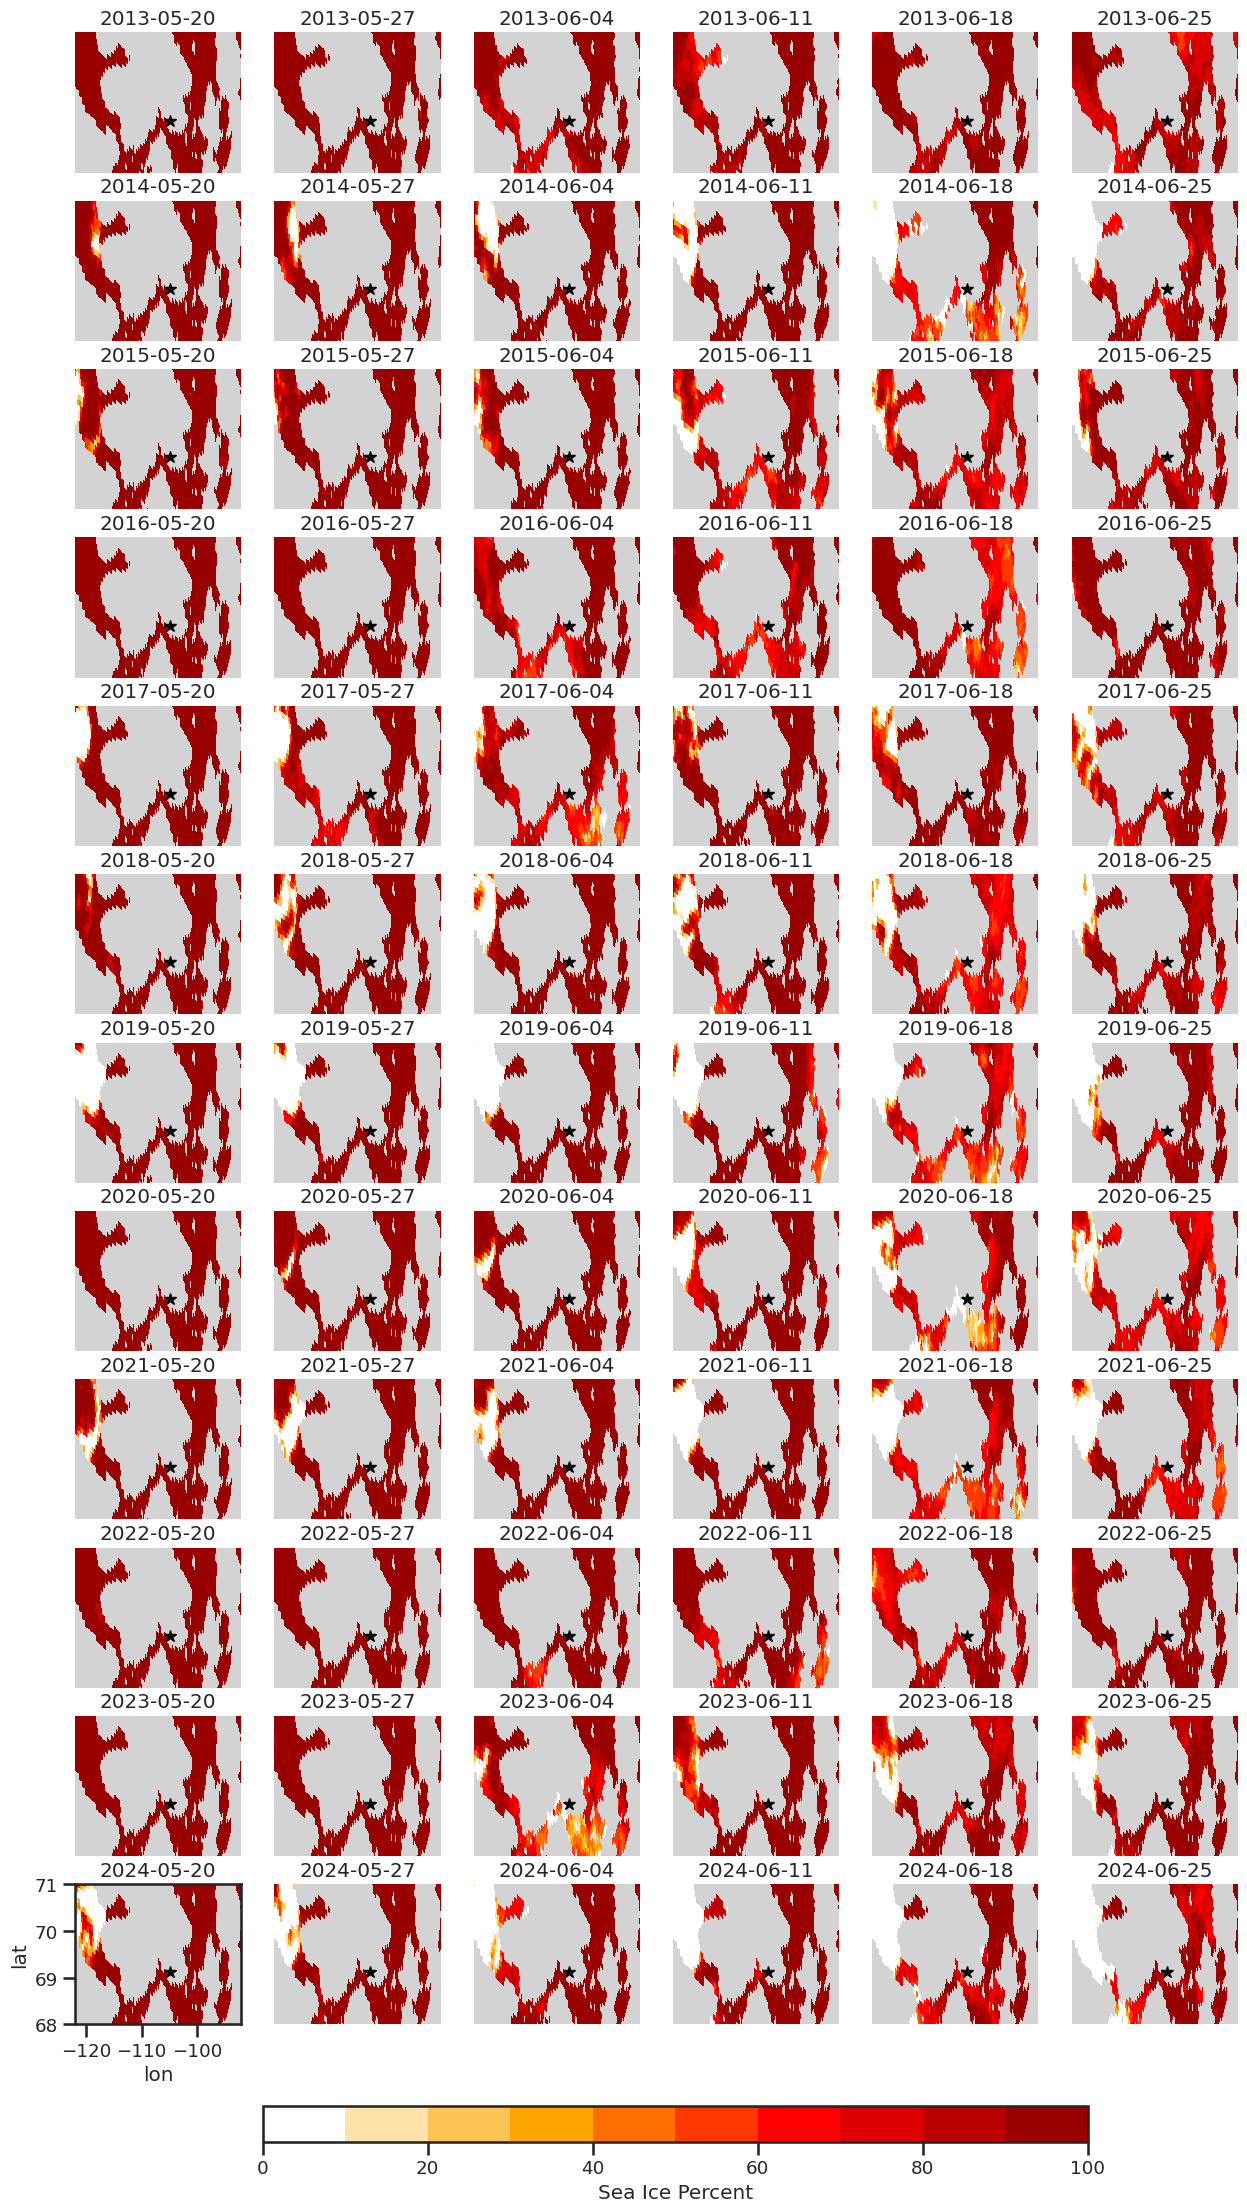

In [10]:
# reads in obs and plots every 7 days as defined by dates array, for every year 2013-2024
dates=['0520','0527','0604','0611','0618','0625']


sns.set_context("talk", font_scale=0.8, rc={"lines.linewidth": 2.5})
#kivalina_lon=[-164.5333+.75] # move inland so can see the ocean nearest
#kivalina_lat=[ 67.7269]

kivalina_lon=CB_lon[0]+0.25
kivalina_lat=CB_lat[0]  #69.1169° N, 105.0597° W
f_out = os.path.join(fig_dir,'SIC_Allyears_2013-2021_'+dates[0]+'_forward.png')

c_vmin=0
c_vmax=100

ncols=3
nrows=2021-2013+4
ncols=6
NPLOTS=nrows*ncols+1
sizefcter=2
#crExt = [1800000.0, 2400000.0, -1500000.0, -1000000.0] # (x0, x1, y0, y1) 
crExt = [1000000.0, 3000000.0, -1500000.0, -500000.0] # (x0, x1, y0, y1) 
(f, axes) = plt.subplots(ncols=ncols, nrows=nrows)
f.set_size_inches(ncols*2.5, nrows*2) # tinker a bit
axes=axes.flatten()
i=0
for yr in np.arange(2013,2025):
    for j in np.arange(0,6):
        date=dates[j]
        FILE_NAME = '/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+date+'.he5'
#        try:
        sic, lat, lon = MakeDataSet2(FILE_NAME)
        #sic= sic.isel(nj=slice(420,625)).isel(ni=slice(100,240))
        sic= sic.isel(nj=slice(500,605)).isel(ni=slice(110,190))

        axi=axes[i]
        p=sic.plot(ax=axi, x='lon', y='lat', add_colorbar=False,
                      cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
        axi.set_ylim([68, 71])
        axi.set_xlim([-122, -92])
        if i!=13*5+1:
            axi.axis('off')
        axi.plot([kivalina_lon], [kivalina_lat], color='k', marker='*')
        axi.set_title("{Y}-{M}-{D}".format(Y=str(yr),M=date[0:2],D=date[2:4]))
#        except:
#            print('No data yet')
        i=i+1

    f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .55, 0.015]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=
                  'Sea Ice Percent', orientation='horizontal')

# Save to file
# f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


In [15]:
IFD_all=[]
IFD2_all=[]
sic_CB = []
for yr in np.arange(2013,2025):
    sic_all=[]
    for mo in np.arange(5,10):
        for day in np.arange(1,32):
            mostr = "{:02d}".format(mo)
            daystr= "{:02d}".format(day)
            FILE_NAME = '/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+mostr+daystr+'.he5'
            try:
                sic, lat, lon = MakeDataSet2(FILE_NAME)
                sic= sic.isel(nj=slice(500,605)).isel(ni=slice(110,190))
                sic = sic.expand_dims('time')
                sic_all.append(sic)
            except:
                if yr == 2013 and mo==5 and day in [11, 12, 13]:
                    print('one of these days')
                    sic['time']=sic['time']+np.timedelta64(1, 'D')
                    sic_all.append(sic)
                    ni=sic.ni
                    nj=sic.nj
                print('no data found'+FILE_NAME)

    sic_all = xr.concat(sic_all, dim='time')
    if yr>2022: # strange that the data sets lose this 
        sic_all['ni']=ni
        sic_all['nj']=nj

    sic_CB.append(sic_all.sel(ni=148,nj=558))

    DOY = np.arange(121,121+len(sic_all['time']))
    sic_all.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':sic_all.time})

    sic_IFD = metrics.calc_IFD(sic_all/100,sic_threshold=0.70, DOY_s=121) 
    sic_IFD2 = metrics.calc_IFD_10day(sic_all/100,sic_threshold=0.5, DOY_s=121, Nday=6) 
    sic_IFD.name ='IFD'
    sic_IFD2.name ='IFD2'

    #sic_IFD=sic_IFD.where(((sic_IFD>122) | (np.isnan(sic_IFD))), other=sic_IFD.max()) 
    sic_IFD=sic_IFD.expand_dims('time')
    sic_IFD2=sic_IFD2.expand_dims('time')

    IFD_all.append(sic_IFD)
    IFD2_all.append(sic_IFD2)


IFD_all = xr.concat(IFD_all, dim='time')
IFD_all.coords['year'] = xr.DataArray(np.arange(2013,2025), dims='time', coords={'time':IFD_all.time})
IFD_all=IFD_all.swap_dims({"time": "year"})
IFD2_all = xr.concat(IFD2_all, dim='time')
IFD2_all.coords['year'] = xr.DataArray(np.arange(2013,2025), dims='time', coords={'time':IFD2_all.time})
IFD2_all=IFD2_all.swap_dims({"time": "year"})
IFD2_all=IFD2_all.astype(float)

sic_CB = xr.concat(sic_CB, dim='time')
#sic_CB = sic_CB.coords['year'] = xr.DataArray(np.arange(2013,2025), dims='time', coords={'time':sic_CB.time})

IFD_all

one of these days
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20130511.he5
one of these days
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20130512.he5
one of these days
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20130513.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20130631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20130931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20140631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20140931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20150631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20150931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20160631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20160931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20170631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20170931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20180631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20180931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20190631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20190931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20200631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20200931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20210631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20210931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20220631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20220931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20230631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20230931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20240631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20240931.he5


/glade/u/home/skygale/polar-bears-international/metrics.py:129: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})
/glade/u/home/skygale/polar-bears-international/metrics.py:141: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({time_dim:'time'})


<xarray.DataArray 'IFD' (year: 12, ni: 80, nj: 105)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [229., 226.,  nan, ..., 227., 121., 273.],
        [229., 230.,  nan, ..., 255., 121., 270.],
        [229., 234.,  nan, ..., 255., 270., 269.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [214., 213.,  nan, ..., 241., 241., 231.],
        [215., 218.,  nan, ..., 241., 232., 232.],
        [218., 225.,  nan, ..., 238., 232., 232.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [176., 176.,  nan, ..., 224., 223., 223.],
        [176., 176.,  nan, ..., 223., 223., 223.],
        [203., 205.,  nan, ..., 217., 214., 216.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [169., 169.,  nan, ..., 220., 227., 229.],
        [169., 169.,  nan, ..., 229., 230., 230.],
        [136., 169.,  nan, ..., 232., 232., 230.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [162., 160.,  nan, ..., 237., 246., 246.],
        [162., 162.,  nan, ..., 250., 249., 246.],
        [166., 166.,  nan, ..., 251., 251., 250.]]])
Coordinates:
    lon      (ni, nj) float32 -125.7 -125.4 -125.1 ... -86.38 -86.17 -85.96
    lat      (ni, nj) float32 67.2 67.18 67.16 67.14 ... 69.61 69.53 69.44 69.36
  * nj       (nj) int32 500 501 502 503 504 505 506 ... 599 600 601 602 603 604
  * ni       (ni) int32 110 111 112 113 114 115 116 ... 184 185 186 187 188 189
    time     (year) datetime64[ns] 2013-05-01 2014-05-01 ... 2024-05-01
    doy      int64 121
  * year     (year) int64 2013 2014 2015 2016 2017 ... 2020 2021 2022 2023 2024

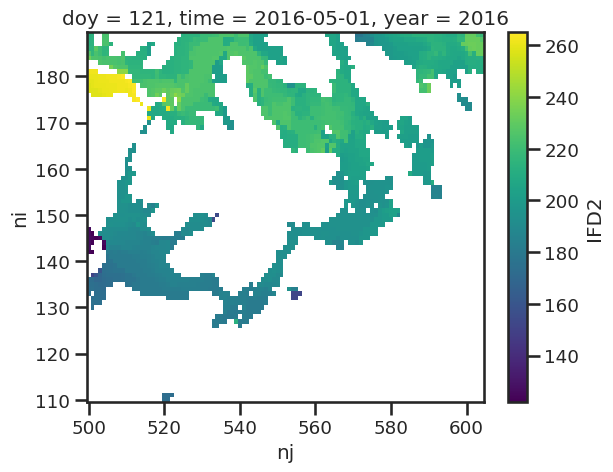

In [16]:
IFD2_all.sel(year=2016).plot()

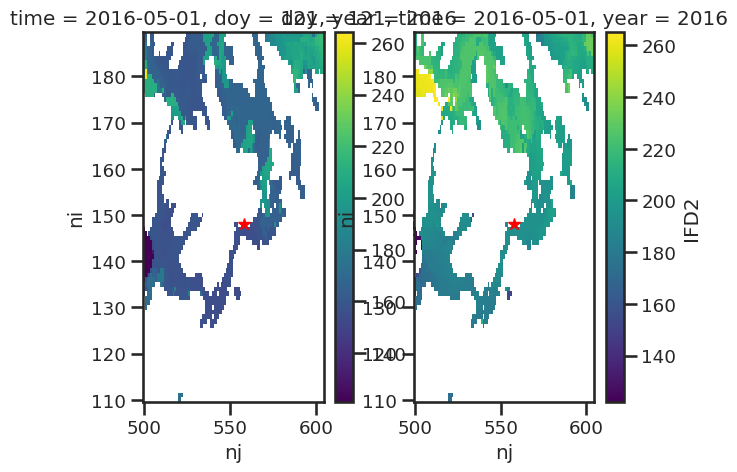

In [17]:
#IFD_all.mean(dim='year').plot()
plt.subplot(121)
IFD_all.sel(year=2016).plot()
plt.plot(558,148, color='r', marker='*')
plt.subplot(122)
IFD2_all.sel(year=2016).plot()
plt.plot(558,148, color='r', marker='*')

saved  ./figures/IFD2_Allyears_2013-2024.png


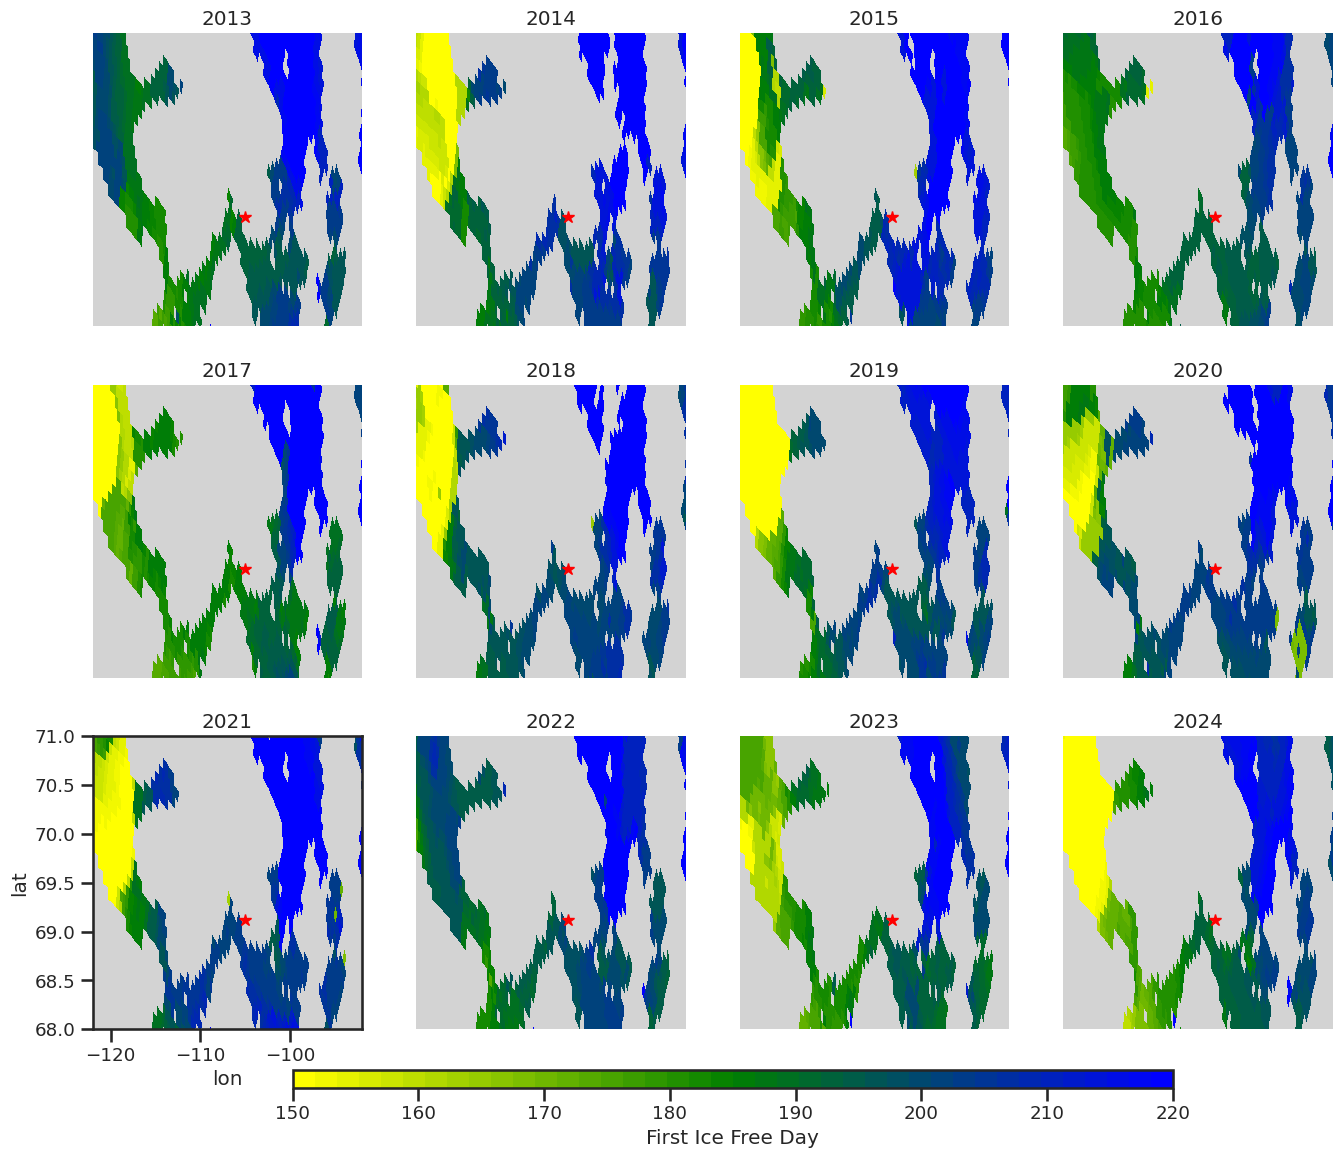

In [18]:
cmap_i = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","green","blue"], N=40)
cmap_i.set_bad(color = 'lightgrey')

ncols=4
nrows=3
(f, axes) = plt.subplots(ncols=ncols, nrows=nrows)
f.set_size_inches(ncols*4, nrows*4) # tinker a bit
axes=axes.flatten()
i=0
for i,yr in enumerate(np.arange(2013,2025)):
    axi=axes[i]
    p=IFD2_all.sel(year=yr).plot(ax=axi, x='lon',y='lat', vmin=150, vmax=220, add_colorbar=False, cmap=cmap_i)
    axi.plot([CB_lon], [CB_lat], color='r', marker='*')
    #axi.plot(-105.429504, 69.06595, color='r', marker='*') # this is where the closes ocean point is but blocks view
    axi.set_ylim([67,71])
    axi.set_xlim([-120,-95])
    axi.set_ylim([68, 71])
    axi.set_xlim([-122, -92])
    
    axi.set_title(str(yr))
    if i != 8:
        axi.axis('off')
    f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .55, 0.015]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=
                  'First Ice Free Day', orientation='horizontal')

f_out = os.path.join(fig_dir,'IFD2_Allyears_2013-2024.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


saved  ./figures/Cambridge_Bay_IFD_2013-2024.png


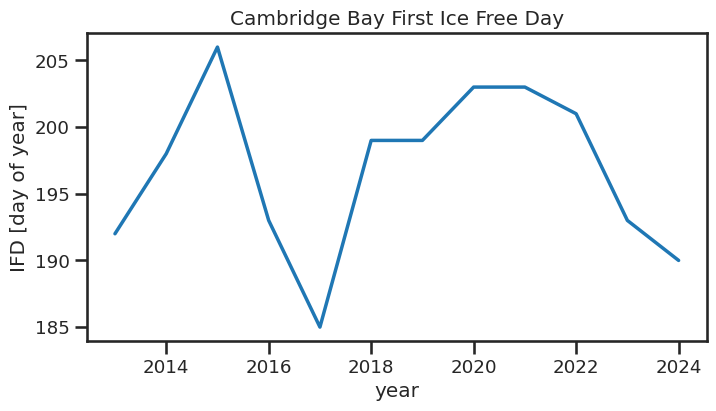

In [19]:
(fig, axes) = plt.subplots(1,1)
fig.set_size_inches(8,4)
IFD2_all.sel(ni=148,nj=558).plot()
#print(IFD_all.sel(year=2014).sel(ni=148,nj=558))  # these are the loses ni,nj
plt.title("Cambridge Bay First Ice Free Day")
plt.ylabel("IFD [day of year]")
f_out = os.path.join(fig_dir,'Cambridge_Bay_IFD_2013-2024.png')
fig.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


In [23]:
yr=2016
sic_all=[]
for mo in np.arange(5,10):
    for day in np.arange(1,32):
        mostr = "{:02d}".format(mo)
        daystr= "{:02d}".format(day)
        FILE_NAME = '/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+mostr+daystr+'.he5'
        try:
            sic, lat, lon = MakeDataSet2(FILE_NAME)
            sic= sic.isel(nj=slice(500,605)).isel(ni=slice(110,190))
            sic = sic.expand_dims('time')
            sic_all.append(sic)
        except:
            if yr == 2013 and mo==5 and day in [11, 12, 13]:
                print('one of these days')
                sic['time']=sic['time']+np.timedelta64(1, 'D')
                sic_all.append(sic)
                ni=sic.ni
                nj=sic.nj
            print('no data found'+FILE_NAME)

sic_all = xr.concat(sic_all, dim='time')
DOY = np.arange(121,121+len(sic_all['time']))
sic_all.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':sic_all.time})

sic_all

no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20160631.he5
no data found/glade/work/skygale/native/AMSR_U2_L3_SeaIce12km_B04_20160931.he5


<xarray.DataArray 'sic' (time: 153, ni: 80, nj: 105)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ 98.,  99.,  nan, ..., 100., 100., 100.],
        [ 97.,  99.,  nan, ..., 100., 100., 100.],
        [ 99.,  99.,  nan, ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ 98.,  98.,  nan, ..., 100., 100., 100.],
        [ 96.,  98.,  nan, ..., 100., 100., 100.],
        [ 97.,  99.,  nan, ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [ 92.,  93.,  nan, ...,   0.,   0.,   0.],
        [ 92.,  94.,  nan, ...,   0.,   0.,   0.],
        [ 95.,  91.,  nan, ...,   0.,   0.,   0.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ 92., 100.,  nan, ...,   0.,   0.,   0.],
        [ 93.,  97.,  nan, ...,   0.,   0.,   0.],
        [ 92.,  92.,  nan, ...,   0.,   0.,   0.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ 95., 100.,  nan, ...,   0.,   0.,   0.],
        [ 94.,  97.,  nan, ...,   0.,   0.,   0.],
        [ 94.,  93.,  nan, ...,   0.,   0.,   0.]]])
Coordinates:
    lon      (ni, nj) float32 -125.7 -125.4 -125.1 ... -86.38 -86.17 -85.96
    lat      (ni, nj) float32 67.2 67.18 67.16 67.14 ... 69.61 69.53 69.44 69.36
  * nj       (nj) int32 500 501 502 503 504 505 506 ... 599 600 601 602 603 604
  * ni       (ni) int32 110 111 112 113 114 115 116 ... 184 185 186 187 188 189
  * time     (time) datetime64[ns] 2016-05-01 2016-05-02 ... 2016-09-30
    doy      (time) int64 121 122 123 124 125 126 ... 268 269 270 271 272 273

saved  ./figures/Cambridge_Bay_SIC_MaytoJuly_2013-2024.png


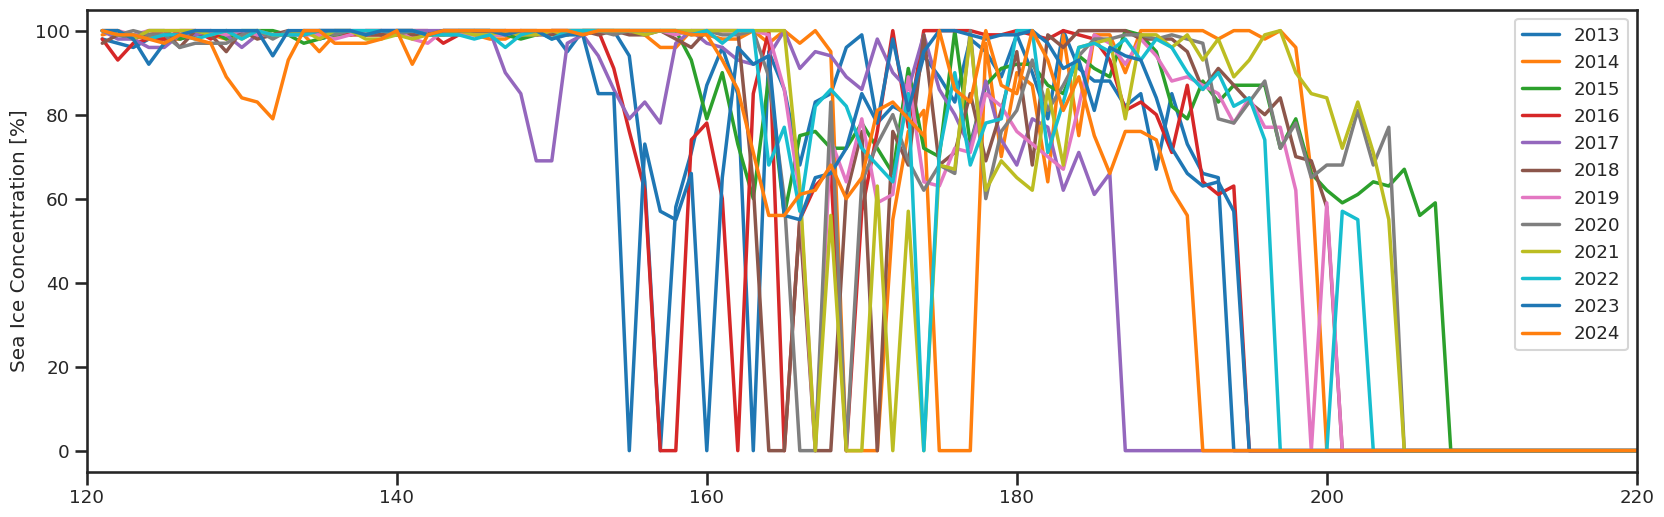

In [24]:
(fig, axes) = plt.subplots(1,1)
fig.set_size_inches(20,6)
for yr in np.arange(2013,2025):
    plt.plot(DOY,sic_CB[pd.to_datetime(sic_CB.time.data).year==yr],label=str(yr))
plt.xlim([120,220])
plt.legend()
plt.ylabel('Sea Ice Concentration [%]')
plt.xlabel
f_out = os.path.join(fig_dir,'Cambridge_Bay_SIC_MaytoJuly_2013-2024.png')
fig.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


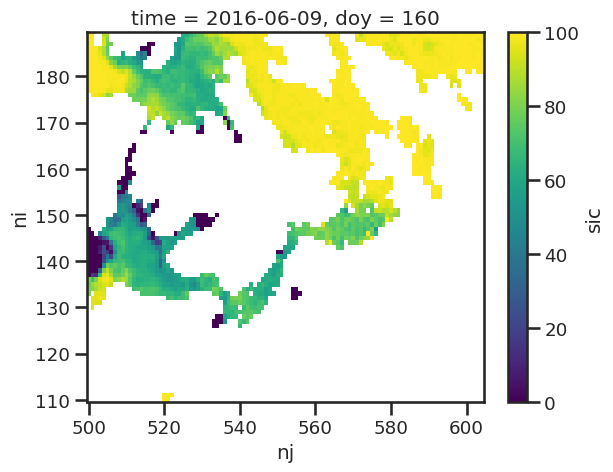

In [25]:
sic_all.isel(time=159-120).plot() # obiously there are bad points occuring in bays and channels

<xarray.DataArray 'IFD' ()>
array(169.)
Coordinates:
    lon      float32 -105.4
    lat      float32 69.07
    nj       int32 558
    ni       int32 148
    time     datetime64[ns] 2014-05-01
    doy      int64 121
    year     int64 2014


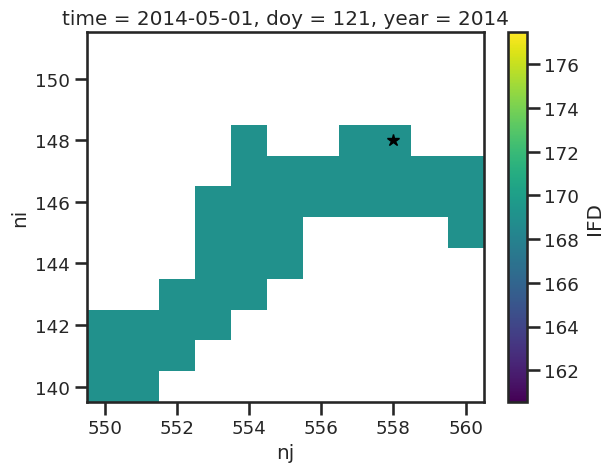

In [26]:
IFD_all.isel(year=1).sel(ni=range(140,152),nj=range(550,561)).plot()
print(IFD_all.sel(year=2014).sel(ni=148,nj=558))  # these are the loses ni,nj
plt.plot(558,148, color='k', marker='*')

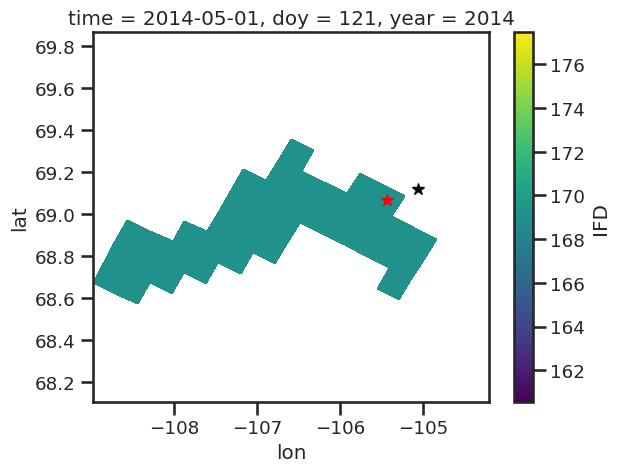

In [27]:
IFD_all.isel(year=1).sel(ni=range(140,152),nj=range(550,561)).plot(x='lon',y='lat')
plt.plot([CB_lon], [CB_lat], color='k', marker='*')
plt.plot(-105.429504, 69.06595, color='r', marker='*')

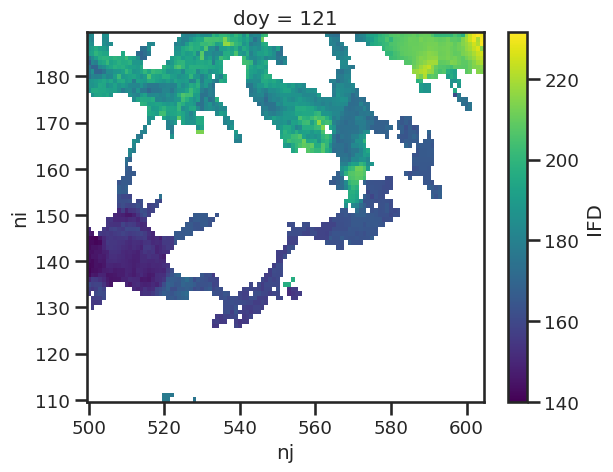

In [28]:
IFD_all.mean(dim='year').plot()

In [29]:
# Calc observed Ice Free Day
# masking is not quite right
da_IFD2 = ds_81.groupby('time.year').apply(metrics.calc_IFD_10day, sic_threshold=0.5, Nday=10 )
da_IFD2.name = 'IFD'

ifd_all2=[]  

for y in ObsYears:
    tmp=ds_81.sel(time=str(y)).min(dim='time') # min sic at anytime during year
    ifd = da_IFD2.sel(year=y).where(tmp<0.5, other=c_vmax) # if never below 0.5 at anytime then set to max poss
    ifd_all2.append(ifd)

ifd_all2=xr.concat(ifd_all2, dim='year')

#climo2=ifd_all2.mean(dim='year')
climo2 = ifd_all2.where(ds_81.isel(time=10).notnull()) # Apply Orig mask 

NameError: name 'ds_81' is not defined

### THE CODE LOOKS LIKE

ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                Nday=10, default_ice_free=pd.to_datetime('2019-06-01').timetuple().tm_yday)

Coordinates:
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * fore_time   (fore_time) timedelta64[ns] 0 days 1 days ... 59 days 60 days
  * init_time   (init_time) datetime64[ns] 2019-08-01
    valid_time  (init_time, fore_time) datetime64[ns] 2019-08-01 ... 2019-09-30

In [31]:
climo2

<xarray.DataArray (year: 10, y: 448, x: 304)>
dask.array<shape=(10, 448, 304), dtype=object, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * year     (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019

In [33]:
ifd_all2=[]  # need to deal with years when never get below 0.15

for y in ObsYears:
    print('Operating on Year ',y)
    tmpo=ds_81.sel(time=str(y))
    
    first_day = np.datetime64(datetime.datetime(int(y),6,1))
    last_day = np.datetime64(datetime.datetime(int(y),10,1))
    print("Looking for times between",first_day,"and",last_day)

    tmpo = tmpo.sel(time=slice(first_day,last_day))
    
    tmp=tmpo.min(dim='time') # min sic at anytime during year
    
    DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([tmpo.time.min().values])]
    print(DOY_first_vt[0])
    tmpo['time'] = tmpo.time - tmpo.time[0]
    print(tmpo)

    # setting the default_ice_free value equal to c_vmin is important
    ifd = metrics.calc_IFD_10day(tmpo, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='time', 
                                    Nday=10, default_ice_free=pd.to_datetime(str(y)+'-06-01').timetuple().tm_yday)


    ifd_all2.append(ifd)

ifd_all2=xr.concat(ifd_all2, dim='year')

#climo3 =ifd_all2.mean(dim='year')
climo3 = ifd_all2.where(ds_81.isel(time=10).notnull()) # Apply Orig mask 



Operating on Year  2010
Looking for times between 2010-06-01T00:00:00.000000 and 2010-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2010 2010 2010 2010 2010 ... 2010 2010 2010 2010 2010
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2011
Looking for times between 2011-06-01T00:00:00.000000 and 2011-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2011 2011 2011 2011 2011 ... 2011 2011 2011 2011 2011
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2012
Looking for times between 2012-06-01T00:00:00.000000 and 2012-10-01T00:00:00.000000
153
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2012 2012 2012 2012 2012 ... 2012 2012 2012 2012 2012
    doy      (time) int64 153 154 155 156 157 158 ... 270 271 272 273 274 275


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2013
Looking for times between 2013-06-01T00:00:00.000000 and 2013-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2013 2013 2013 2013 2013 ... 2013 2013 2013 2013 2013
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2014
Looking for times between 2014-06-01T00:00:00.000000 and 2014-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2014 2014 2014 2014 2014 ... 2014 2014 2014 2014 2014
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2015
Looking for times between 2015-06-01T00:00:00.000000 and 2015-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2015 2015 2015 2015 2015 ... 2015 2015 2015 2015 2015
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2016
Looking for times between 2016-06-01T00:00:00.000000 and 2016-10-01T00:00:00.000000
153
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2016 2016 2016 2016 2016 ... 2016 2016 2016 2016 2016
    doy      (time) int64 153 154 155 156 157 158 ... 270 271 272 273 274 275


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2017
Looking for times between 2017-06-01T00:00:00.000000 and 2017-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2017 2017 2017 2017 2017 ... 2017 2017 2017 2017 2017
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2018
Looking for times between 2018-06-01T00:00:00.000000 and 2018-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2018 2018 2018 2018 2018 ... 2018 2018 2018 2018 2018
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2019
Looking for times between 2019-06-01T00:00:00.000000 and 2019-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2019 2019 2019 2019 2019 ... 2019 2019 2019 2019 2019
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


<xarray.DataArray (year: 10, y: 448, x: 304)>
dask.array<shape=(10, 448, 304), dtype=float64, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * year     (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019

In [7]:
#cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
cmap_c.set_bad(color = 'lightgrey')


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


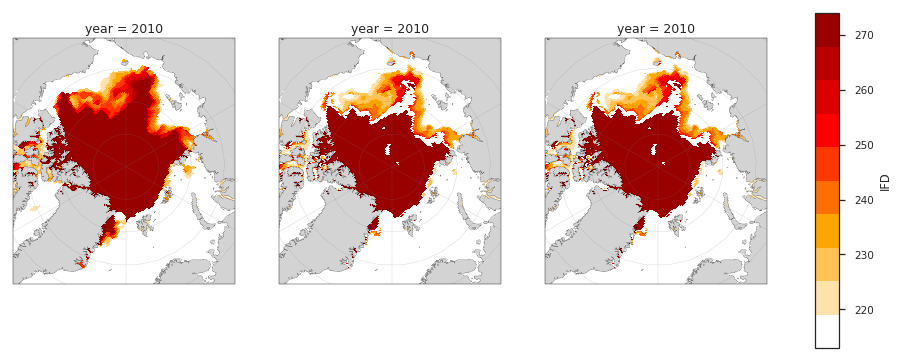

In [39]:
NPLOTS = 4
year=2010
c_vmin=213
#central_extent = [-3850000, 3725000, -5325000, 5850000] # (x0, x1, y0, y1
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1

(f, axes) = ice_plot.multi_polar_axis(ncols=3, nrows=1, Nplots=NPLOTS, sizefcter=3, extent=central_extent, central_longitude=0)

i=0
p = climo.sel(year=year).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)


i=1
p = climo2.sel(year=year).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)


i=2
p = climo3.sel(year=year).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)



cbar_ax = f.add_axes([0.95, 0.07, .025, 0.775]) #  [left, bottom, width, height] w
c_label = 'IFD'
cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')

In [38]:
print(c_vmin,c_vmax)

213 274


In [ ]:
    # Plot perenial ice as black
    #cper_mask = ds_IFD_All.sel(model=cmod)
    pb = cper_mask.where(cper_mask==275).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

    # Add init date
#    axes[i].annotate(pd.to_datetime(ds_IFD_All.sel(model=cmod).init_date.values).strftime('%m/%d'), xy=(.6, -.15), xycoords='axes fraction', )

# MME Mean
i = i + 1

cper_mask = ds_MME_avg.isel(init_time=0)

pmme = cper_mask.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

# Plot perenial ice as black
pb = cper_mask.where(cper_mask>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_b,
                      vmin=0, vmax=1)    


axes[i].set_title('Multi-Forecast\nMean')


PlotObs = True
if PlotObs:       
    print('Climo 10 yr')
    # Climo10yrs
    i = i + 1

    pmme = climo.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False, 
                                      cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

    # Plot perenial ice as black
    pb = climo.where(climo>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    


    axes[i].set_title('Climatology\nLast 10 yrs')
    

# MME Standard deviation
i = i + 1

print('MME sigma')

fld = ds_MME_std.isel(init_time=0)
landmask = fld.notnull()
fld = fld.where(cper_mask>c_vmin,other=0)
fld = fld.where(landmask)

pstd = fld.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_std,vmin=ds_MME_std.min().values, vmax=ds_MME_std.max().values)
axes[i].set_title('σ of\nForecasts')



# Make pretty
f.subplots_adjust(bottom=0.05)

cbar1vertical = True
if cbar1vertical:
#    cbar_ax = f.add_axes([0.95, 0.36, .05, 0.5]) #  [left, bottom, width, height]   span just top rows
    cbar_ax = f.add_axes([0.95, 0.07, .025, 0.775]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
else:
    cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

#f.subplots_adjust(right=0.05)
#cbar_ax_2 = f.add_axes([0.925, 0.1, .025, .28]) #  [left, bottom, width, height] w   FAR RIGHT
#cbar_ax_2 = f.add_axes([0.75, 0.1, .025, .28]) #  [left, bottom, width, height] w
#cbar_ax_2 = f.add_axes([0.35, 0.07, .025, .20]) #  [left, bottom, width, height] w

#cbar_ax_2 = f.add_axes([0.76, 0.07, .025, .20]) #  [left, bottom, width, height] w
cbar_ax_2 = f.add_axes([0.53, 0.08, .025, .18]) #  [left, bottom, width, height] w

cbar2 = f.colorbar(pstd, cax=cbar_ax_2, label='days', orientation='vertical')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)